In [1]:
import torch
import intel_extension_for_pytorch as ipex
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR




#hyperparamiter tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import torch.optim as optim

torch.manual_seed(42)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libpng16.so.16: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/intel_extension_for_pytorch/llm/__init__.py:9: UserWarning: failed to use huggingface generation fuctions due to: No module named 'transformers'.
  warnings.warn(f"failed to use huggingface generation fuctions due to: {e}.")


In [2]:
import pandas as pd
import numpy as np
import os
import glob
import shap
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from sklearn import metrics
#from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

#When using colab...
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Data/'

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
df = pd.read_csv('Data/2013-24_model_input_cluster_update_v4.csv')

In [5]:
rolling_stats = [col for col in df.columns if col.endswith('_rolling')]

# create opponent columns and compute the difference for each rolling stat
for stat in rolling_stats:
    # Shift to get opponent's stats
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[stat].shift(-1)
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']

# for the second team (reverse the shift), fill in the NaN values
for stat in rolling_stats:
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[f'opp_{stat}'].fillna(df.groupby('GAME_ID')[stat].shift(1))
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']  # Difference between team's and opponent's rolling stats

# NaN check
print(df.isnull().sum())

SEASON_YEAR                0
TEAM_ID                    0
TEAM_ABBREVIATION_x        0
TEAM_NAME_x                0
GAME_ID                    0
                          ..
diff_PACE_PER40_rolling    0
opp_POSS_rolling           0
diff_POSS_rolling          0
opp_PIE_rolling            0
diff_PIE_rolling           0
Length: 189, dtype: int64


In [6]:
## match up teams and create diff column
# identify the rolling stats columns
rolling_stats = [col for col in df.columns if col.endswith('_rolling')] + ['win_percentage']

cluster_cols = [col for col in df.columns if col.startswith('cluster_')]

for stat in rolling_stats:
    # Shift to get opponent's stats
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[stat].shift(-1)
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']

for cluster in cluster_cols:
    # Shift to get opponent's clusters
    df[f'opp_{cluster}'] = df.groupby('GAME_ID')[cluster].shift(-1)
    df[f'diff_{cluster}'] = df[cluster] - df[f'opp_{cluster}']

for stat in rolling_stats:
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[f'opp_{stat}'].fillna(df.groupby('GAME_ID')[stat].shift(1))
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']  

for cluster in cluster_cols:
    df[f'opp_{cluster}'] = df.groupby('GAME_ID')[f'opp_{cluster}'].fillna(df.groupby('GAME_ID')[cluster].shift(1))
    df[f'diff_{cluster}'] = df[cluster] - df[f'opp_{cluster}']

In [7]:
df

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,Season,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_AWAY,cumulative_wins,games_played,win_percentage,FGM_rolling,FGA_rolling,FG_PCT_rolling,FG3M_rolling,FG3A_rolling,FG3_PCT_rolling,FTM_rolling,FTA_rolling,FT_PCT_rolling,OREB_rolling,DREB_rolling,REB_rolling,AST_rolling,TOV_rolling,STL_rolling,BLK_rolling,BLKA_rolling,PF_rolling,PFD_rolling,PTS_rolling,PLUS_MINUS_rolling,E_OFF_RATING_rolling,OFF_RATING_rolling,E_DEF_RATING_rolling,DEF_RATING_rolling,E_NET_RATING_rolling,NET_RATING_rolling,AST_PCT_rolling,AST_TOV_rolling,AST_RATIO_rolling,E_TM_TOV_PCT_rolling,TM_TOV_PCT_rolling,EFG_PCT_rolling,TS_PCT_rolling,E_USG_PCT_rolling,E_PACE_rolling,PACE_rolling,PACE_PER40_rolling,POSS_rolling,PIE_rolling,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,opp_FGM_rolling,diff_FGM_rolling,opp_FGA_rolling,diff_FGA_rolling,opp_FG_PCT_rolling,diff_FG_PCT_rolling,opp_FG3M_rolling,diff_FG3M_rolling,opp_FG3A_rolling,diff_FG3A_rolling,opp_FG3_PCT_rolling,diff_FG3_PCT_rolling,opp_FTM_rolling,diff_FTM_rolling,opp_FTA_rolling,diff_FTA_rolling,opp_FT_PCT_rolling,diff_FT_PCT_rolling,opp_OREB_rolling,diff_OREB_rolling,opp_DREB_rolling,diff_DREB_rolling,opp_REB_rolling,diff_REB_rolling,opp_AST_rolling,diff_AST_rolling,opp_TOV_rolling,diff_TOV_rolling,opp_STL_rolling,diff_STL_rolling,opp_BLK_rolling,diff_BLK_rolling,opp_BLKA_rolling,diff_BLKA_rolling,opp_PF_rolling,diff_PF_rolling,opp_PFD_rolling,diff_PFD_rolling,opp_PTS_rolling,diff_PTS_rolling,opp_PLUS_MINUS_rolling,diff_PLUS_MINUS_rolling,opp_E_OFF_RATING_rolling,diff_E_OFF_RATING_rolling,opp_OFF_RATING_rolling,diff_OFF_RATING_rolling,opp_E_DEF_RATING_rolling,diff_E_DEF_RATING_rolling,opp_DEF_RATING_rolling,diff_DEF_RATING_rolling,opp_E_NET_RATING_rolling,diff_E_NET_RATING_rolling,opp_NET_RATING_rolling,diff_NET_RATING_rolling,opp_AST_PCT_rolling,diff_AST_PCT_rolling,opp_AST_TOV_rolling,diff_AST_TOV_rolling,opp_AST_RATIO_rolling,diff_AST_RATIO_rolling,opp_E_TM_TOV_PCT_rolling,diff_E_TM_TOV_PCT_rolling,opp_TM_TOV_PCT_rolling,diff_TM_TOV_PCT_rolling,opp_EFG_PCT_rolling,diff_EFG_PCT_rolling,opp_TS_PCT_rolling,diff_TS_PCT_rolling,opp_E_USG_PCT_rolling,diff_E_USG_PCT_rolling,opp_E_PACE_rolling,diff_E_PACE_rolling,opp_PACE_rolling,diff_PACE_rolling,opp_PACE_PER40_rolling,diff_PACE_PER40_rolling,opp_POSS_rolling,diff_POSS_rolling,opp_PIE_rolling,diff_PIE_rolling,opp_opp_FGM_rolling,diff_opp_FGM_rolling,opp_diff_FGM_rolling,diff_diff_FGM_rolling,opp_opp_FGA_rolling,diff_opp_FGA_rolling,opp_diff_FGA_rolling,diff_diff_FGA_rolling,opp_opp_FG_PCT_rolling,diff_opp_FG_PCT_rolling,opp_diff_FG_PCT_rolling,diff_diff_FG_PCT_rolling,opp_opp_FG3M_rolling,diff_opp_FG3M_rolling,opp_diff_FG3M_rolling,diff_diff_FG3M_rolling,opp_opp_FG3A_rolling,diff_opp_FG3A_rolling,opp_diff_FG3A_rolling,diff_diff_FG3A_rolling,opp_opp_FG3_PCT_rolling,diff_opp_FG3_PCT_rolling,opp_diff_FG3_PCT_rolling,diff_diff_FG3_PCT_rolling,opp_opp_FTM_rolling,diff_opp_FTM_rolling,opp_diff_FTM_rolling,diff_diff_FTM_rolling,opp_opp_FTA_rolling,diff_opp_FTA_rolling,opp_diff_FTA_rolling,diff_diff_FTA_rolling,opp_opp_FT_PCT_rolling,diff_opp_FT_PCT_rolling,opp_diff_FT_PCT_rolling,diff_diff_FT_PCT_rolling,opp_opp_OREB_rolling,diff_opp_OREB_rolling,opp_diff_OREB_rolling,diff_diff_OREB_rolling,opp_opp_DREB_rolling,diff_opp_DREB_rolling,opp_diff_DREB_rolling,diff_diff_DREB_rolling,opp_opp_REB_rolling,diff_opp_REB_rolling,opp_diff_REB_rolling,diff_diff_REB_rolling,opp_opp_AST_rolling,diff_opp_AST_rolling,opp_diff_AST_rolling,diff_diff_AST_rolling,opp_opp_TOV_rolling,diff_opp_TOV_rolling,opp_diff_TOV_rolling,diff_diff_TOV_rolling,opp_opp_STL_roll

In [8]:
columns_to_keep = ['SEASON_YEAR', 'TEAM_ID', 'GAME_ID', 'WL', 'HOME_AWAY', 'win_percentage', 'opp_win_percentage'] + \
                  [col for col in df.columns if (col.startswith('diff_') and col.endswith('_rolling')) or col.startswith('diff_cluster_')]
df_model = df[columns_to_keep]

df_model.head()

,SEASON_YEAR,TEAM_ID,GAME_ID,WL,HOME_AWAY,win_percentage,opp_win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,diff_FG3M_rolling,diff_FG3A_rolling,diff_FG3_PCT_rolling,diff_FTM_rolling,diff_FTA_rolling,diff_FT_PCT_rolling,diff_OREB_rolling,diff_DREB_rolling,diff_REB_rolling,diff_AST_rolling,diff_TOV_rolling,diff_STL_rolling,diff_BLK_rolling,diff_BLKA_rolling,diff_PF_rolling,diff_PFD_rolling,diff_PTS_rolling,diff_PLUS_MINUS_rolling,diff_E_OFF_RATING_rolling,diff_OFF_RATING_rolling,diff_E_DEF_RATING_rolling,diff_DEF_RATING_rolling,diff_E_NET_RATING_rolling,diff_NET_RATING_rolling,diff_AST_PCT_rolling,diff_AST_TOV_rolling,diff_AST_RATIO_rolling,diff_E_TM_TOV_PCT_rolling,diff_TM_TOV_PCT_rolling,diff_EFG_PCT_rolling,diff_TS_PCT_rolling,diff_E_USG_PCT_rolling,diff_E_PACE_rolling,diff_PACE_rolling,diff_PACE_PER40_rolling,diff_POSS_rolling,diff_PIE_rolling,diff_opp_FGM_rolling,diff_diff_FGM_rolling,diff_opp_FGA_rolling,diff_diff_FGA_rolling,diff_opp_FG_PCT_rolling,diff_diff_FG_PCT_rolling,diff_opp_FG3M_rolling,diff_diff_FG3M_rolling,diff_opp_FG3A_rolling,diff_diff_FG3A_rolling,diff_opp_FG3_PCT_rolling,diff_diff_FG3_PCT_rolling,diff_opp_FTM_rolling,diff_diff_FTM_rolling,diff_opp_FTA_rolling,diff_diff_FTA_rolling,diff_opp_FT_PCT_rolling,diff_diff_FT_PCT_rolling,diff_opp_OREB_rolling,diff_diff_OREB_rolling,diff_opp_DREB_rolling,diff_diff_DREB_rolling,diff_opp_REB_rolling,diff_diff_REB_rolling,diff_opp_AST_rolling,diff_diff_AST_rolling,diff_opp_TOV_rolling,diff_diff_TOV_rolling,diff_opp_STL_rolling,diff_diff_STL_rolling,diff_opp_BLK_rolling,diff_diff_BLK_rolling,diff_opp_BLKA_rolling,diff_diff_BLKA_rolling,diff_opp_PF_rolling,diff_diff_PF_rolling,diff_opp_PFD_rolling,diff_diff_PFD_rolling,diff_opp_PTS_rolling,diff_diff_PTS_rolling,diff_opp_PLUS_MINUS_rolling,diff_diff_PLUS_MINUS_rolling,diff_opp_E_OFF_RATING_rolling,diff_diff_E_OFF_RATING_rolling,diff_opp_OFF_RATING_rolling,diff_diff_OFF_RATING_rolling,diff_opp_E_DEF_RATING_rolling,diff_diff_E_DEF_RATING_rolling,diff_opp_DEF_RATING_rolling,diff_diff_DEF_RATING_rolling,diff_opp_E_NET_RATING_rolling,diff_diff_E_NET_RATING_rolling,diff_opp_NET_RATING_rolling,diff_diff_NET_RATING_rolling,diff_opp_AST_PCT_rolling,diff_diff_AST_PCT_rolling,diff_opp_AST_TOV_rolling,diff_diff_AST_TOV_rolling,diff_opp_AST_RATIO_rolling,diff_diff_AST_RATIO_rolling,diff_opp_E_TM_TOV_PCT_rolling,diff_diff_E_TM_TOV_PCT_rolling,diff_opp_TM_TOV_PCT_rolling,diff_diff_TM_TOV_PCT_rolling,diff_opp_EFG_PCT_rolling,diff_diff_EFG_PCT_rolling,diff_opp_TS_PCT_rolling,diff_diff_TS_PCT_rolling,diff_opp_E_USG_PCT_rolling,diff_diff_E_USG_PCT_rolling,diff_opp_E_PACE_rolling,diff_diff_E_PACE_rolling,diff_opp_PACE_rolling,diff_diff_PACE_rolling,diff_opp_PACE_PER40_rolling,diff_diff_PACE_PER40_rolling,diff_opp_POSS_rolling,diff_diff_POSS_rolling,diff_opp_PIE_rolling,diff_diff_PIE_rolling,diff_cluster_0,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9,diff_cluster_10
0,2013-14,1610612737,21300023,1,1,0.000000,1.000000,-1.000000,-10.000000,0.045000,3.000000,7.000000,0.039000,15.000000,12.000000,0.249000,-14.000000,-1.000000,-15.000000,12.000000,-1.000000,7.000000,-1.000000,-5.000000,-5.000000,-5.000000,16.000000,-15.000000,7.600,3.700000,24.500000,20.000000,-16.900000,-16.300000,0.335000,0.760000,8.300000,-2.482000,-3.300000,0.068000,0.112000,0.001000,7.540000,11.500000,9.580000,12.000000,-0.049000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.062429,-0.001571,0.019857,0.024857,0.0,0.0,0.040714,-0.022571,0.012571,0.0
1,2013-14,1610612737,21300046,0,0,0.500000,0.333333,0.833333,-11.500000,0.073833,-1.000000,-1.166667,-0.023667,6.500000,8.666667,0.003667,-5.6666

In [9]:
 df_model[df_model['GAME_ID'].astype(str).str.endswith('0001')]

,SEASON_YEAR,TEAM_ID,GAME_ID,WL,HOME_AWAY,win_percentage,opp_win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,diff_FG3M_rolling,diff_FG3A_rolling,diff_FG3_PCT_rolling,diff_FTM_rolling,diff_FTA_rolling,diff_FT_PCT_rolling,diff_OREB_rolling,diff_DREB_rolling,diff_REB_rolling,diff_AST_rolling,diff_TOV_rolling,diff_STL_rolling,diff_BLK_rolling,diff_BLKA_rolling,diff_PF_rolling,diff_PFD_rolling,diff_PTS_rolling,diff_PLUS_MINUS_rolling,diff_E_OFF_RATING_rolling,diff_OFF_RATING_rolling,diff_E_DEF_RATING_rolling,diff_DEF_RATING_rolling,diff_E_NET_RATING_rolling,diff_NET_RATING_rolling,diff_AST_PCT_rolling,diff_AST_TOV_rolling,diff_AST_RATIO_rolling,diff_E_TM_TOV_PCT_rolling,diff_TM_TOV_PCT_rolling,diff_EFG_PCT_rolling,diff_TS_PCT_rolling,diff_E_USG_PCT_rolling,diff_E_PACE_rolling,diff_PACE_rolling,diff_PACE_PER40_rolling,diff_POSS_rolling,diff_PIE_rolling,diff_opp_FGM_rolling,diff_diff_FGM_rolling,diff_opp_FGA_rolling,diff_diff_FGA_rolling,diff_opp_FG_PCT_rolling,diff_diff_FG_PCT_rolling,diff_opp_FG3M_rolling,diff_diff_FG3M_rolling,diff_opp_FG3A_rolling,diff_diff_FG3A_rolling,diff_opp_FG3_PCT_rolling,diff_diff_FG3_PCT_rolling,diff_opp_FTM_rolling,diff_diff_FTM_rolling,diff_opp_FTA_rolling,diff_diff_FTA_rolling,diff_opp_FT_PCT_rolling,diff_diff_FT_PCT_rolling,diff_opp_OREB_rolling,diff_diff_OREB_rolling,diff_opp_DREB_rolling,diff_diff_DREB_rolling,diff_opp_REB_rolling,diff_diff_REB_rolling,diff_opp_AST_rolling,diff_diff_AST_rolling,diff_opp_TOV_rolling,diff_diff_TOV_rolling,diff_opp_STL_rolling,diff_diff_STL_rolling,diff_opp_BLK_rolling,diff_diff_BLK_rolling,diff_opp_BLKA_rolling,diff_diff_BLKA_rolling,diff_opp_PF_rolling,diff_diff_PF_rolling,diff_opp_PFD_rolling,diff_diff_PFD_rolling,diff_opp_PTS_rolling,diff_diff_PTS_rolling,diff_opp_PLUS_MINUS_rolling,diff_diff_PLUS_MINUS_rolling,diff_opp_E_OFF_RATING_rolling,diff_diff_E_OFF_RATING_rolling,diff_opp_OFF_RATING_rolling,diff_diff_OFF_RATING_rolling,diff_opp_E_DEF_RATING_rolling,diff_diff_E_DEF_RATING_rolling,diff_opp_DEF_RATING_rolling,diff_diff_DEF_RATING_rolling,diff_opp_E_NET_RATING_rolling,diff_diff_E_NET_RATING_rolling,diff_opp_NET_RATING_rolling,diff_diff_NET_RATING_rolling,diff_opp_AST_PCT_rolling,diff_diff_AST_PCT_rolling,diff_opp_AST_TOV_rolling,diff_diff_AST_TOV_rolling,diff_opp_AST_RATIO_rolling,diff_diff_AST_RATIO_rolling,diff_opp_E_TM_TOV_PCT_rolling,diff_diff_E_TM_TOV_PCT_rolling,diff_opp_TM_TOV_PCT_rolling,diff_diff_TM_TOV_PCT_rolling,diff_opp_EFG_PCT_rolling,diff_diff_EFG_PCT_rolling,diff_opp_TS_PCT_rolling,diff_diff_TS_PCT_rolling,diff_opp_E_USG_PCT_rolling,diff_diff_E_USG_PCT_rolling,diff_opp_E_PACE_rolling,diff_diff_E_PACE_rolling,diff_opp_PACE_rolling,diff_diff_PACE_rolling,diff_opp_PACE_PER40_rolling,diff_diff_PACE_PER40_rolling,diff_opp_POSS_rolling,diff_diff_POSS_rolling,diff_opp_PIE_rolling,diff_diff_PIE_rolling,diff_cluster_0,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9,diff_cluster_10


In [10]:
len(list(df.columns))

373

In [11]:
# List of columns to keep
columns_to_keep = [
    'SEASON_YEAR',
    'TEAM_ID',
    'GAME_ID',
    'WL',
    'HOME_AWAY',
    'win_percentage',
    'opp_win_percentage',
    'diff_FGM_rolling',
    'diff_FGA_rolling',
    'diff_FG_PCT_rolling',
    'diff_FG3M_rolling',
    'diff_FG3A_rolling',
    'diff_FG3_PCT_rolling',
    'diff_FTM_rolling',
    'diff_FTA_rolling',
    'diff_FT_PCT_rolling',
    'diff_OREB_rolling',
    'diff_DREB_rolling',
    'diff_REB_rolling',
    'diff_AST_rolling',
    'diff_TOV_rolling',
    'diff_STL_rolling',
    'diff_BLK_rolling',
    'diff_BLKA_rolling',
    'diff_PF_rolling',
    'diff_PFD_rolling',
    'diff_PTS_rolling',
    'diff_PLUS_MINUS_rolling',
    #'diff_E_OFF_RATING_rolling',
    'diff_OFF_RATING_rolling',
    #'diff_E_DEF_RATING_rolling',
    'diff_DEF_RATING_rolling',
   # 'diff_E_NET_RATING_rolling',
    'diff_NET_RATING_rolling',
    'diff_AST_PCT_rolling',
    'diff_AST_TOV_rolling',
    'diff_AST_RATIO_rolling',
    #'diff_E_TM_TOV_PCT_rolling',
    'diff_TM_TOV_PCT_rolling',
    'diff_EFG_PCT_rolling',
    'diff_TS_PCT_rolling',
   # 'diff_E_USG_PCT_rolling',
   # 'diff_E_PACE_rolling',
    'diff_PACE_rolling',
    'diff_PACE_PER40_rolling',
    'diff_POSS_rolling',
    'diff_PIE_rolling',
    'diff_cluster_0',
    'diff_cluster_1',
    'diff_cluster_2',
    'diff_cluster_3',
    'diff_cluster_4',
    'diff_cluster_5',
    'diff_cluster_6',
    'diff_cluster_7',
    'diff_cluster_8',
    'diff_cluster_9',
    'diff_cluster_10',

]

df_model_cleaned = df_model[columns_to_keep]



In [12]:
df_model_cleaned

,SEASON_YEAR,TEAM_ID,GAME_ID,WL,HOME_AWAY,win_percentage,opp_win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,diff_FG3M_rolling,diff_FG3A_rolling,diff_FG3_PCT_rolling,diff_FTM_rolling,diff_FTA_rolling,diff_FT_PCT_rolling,diff_OREB_rolling,diff_DREB_rolling,diff_REB_rolling,diff_AST_rolling,diff_TOV_rolling,diff_STL_rolling,diff_BLK_rolling,diff_BLKA_rolling,diff_PF_rolling,diff_PFD_rolling,diff_PTS_rolling,diff_PLUS_MINUS_rolling,diff_OFF_RATING_rolling,diff_DEF_RATING_rolling,diff_NET_RATING_rolling,diff_AST_PCT_rolling,diff_AST_TOV_rolling,diff_AST_RATIO_rolling,diff_TM_TOV_PCT_rolling,diff_EFG_PCT_rolling,diff_TS_PCT_rolling,diff_PACE_rolling,diff_PACE_PER40_rolling,diff_POSS_rolling,diff_PIE_rolling,diff_cluster_0,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9,diff_cluster_10
0,2013-14,1610612737,21300023,1,1,0.000000,1.000000,-1.000000,-10.000000,0.045000,3.000000,7.000000,0.039000,15.000000,12.000000,0.249000,-14.000000,-1.000000,-15.000000,12.000000,-1.000000,7.000000,-1.000000,-5.000000,-5.000000,-5.000000,16.000000,-15.000000,3.700000,20.000000,-16.300000,0.335000,0.760000,8.300000,-3.300000,0.068000,0.112000,11.500000,9.580000,12.000000,-0.049000,0.000000,-0.062429,-0.001571,0.019857,0.024857,0.00000,0.000000,0.040714,-0.022571,0.012571,0.000000
1,2013-14,1610612737,21300046,0,0,0.500000,0.333333,0.833333,-11.500000,0.073833,-1.000000,-1.166667,-0.023667,6.500000,8.666667,0.003667,-5.666667,-5.000000,-10.666667,4.166667,-1.000000,5.833333,-1.666667,-0.333333,-5.333333,3.166667,7.166667,7.000000,7.066667,0.666667,6.433333,0.090500,0.333333,3.616667,-1.033333,0.075500,0.083500,-0.083333,-0.066667,0.166667,0.100333,0.000000,0.074429,0.051571,-0.130771,-0.101543,0.00000,0.000000,-0.214800,-0.278514,-0.099286,0.000000
2,2013-14,1610612737,21300059,1,0,0.333333,0.333333,4.666667,-1.333333,0.063667,2.333333,1.666667,0.070667,0.333333,4.333333,-0.112000,-5.000000,4.333333,-0.666667,9.000000,1.333333,2.666667,-0.666667,-2.666667,-5.666667,-0.333333,12.000000,4.666667,2.500000,-2.000000,4.500000,0.179000,0.446667,5.633333,0.100000,0.078333,0.061333,8.833333,7.363333,9.333333,0.085667,0.000000,-0.005190,0.109714,0.025500,-0.091762,0.00000,0.000000,-0.046548,-0.061214,-0.091095,0.000000
3,2013-14,1610612737,21300071,0,0,0.500000,0.000000,3.000000,-6.000000,0.064667,2.083333,5.416667,0.005250,3.333333,5.833333,-0.068750,-4.916667,-2.583333,-7.500000,7.416667,-1.416667,6.416667,-2.166667,-2.250000,-3.750000,-0.083333,11.416667,8.583333,8.700000,0.291667,8.408333,0.152833,0.238333,5.233333,-1.741667,0.080000,0.075083,2.625000,2.190000,2.916667,0.074917,0.000000,0.034571,0.093857,0.100143,0.038429,0.00000,0.000000,0.186429,-0.153857,-0.118429,0.000000
4,2013-14,1610612737,21300086,1,1,0.400000,0.500000,1.000000,4.500000,-0.016250,2.000000,4.500000,0.022750,-0.750000,1.750000,-0.081750,-0.500000,-8.000000,-8.500000,6.500000,-4.500000,2.250000,0.750000,0.500000,-1.750000,1.500000,3.250000,-9.750000,1.150000,11.800000,-10.650000,0.147000,0.937500,3.850000,-4.975000,-0.007500,-0.016250,1.875000,1.565000,2.250000,-0.057500,0.000000,0.022571,0.112857,0.201571,-0.117429,0.00000,0.000000,0.041286,-0.151571,-0.054571,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25975,2023-24,1610612766,22301135,0,1,0.240000,0.680000,0.500000,-1.750000,0.019000,4.250000,5.750000,0.066000,-4.750000,-7.750000,0.045750,-4.000000,0.750000,-3.250000,1.750000,-2.500000,-2.500000,-3.000000,-2.250000,2.000000,-2.750000,0.500000,8.000000,5.625000,-2.250000,7.900000,0.032750,0.920000,2.175000,-2.025000,0.045500,0.038750,-4.375000,-3.642500,-4.500000,0.030750,0.000000,-0.194167,0.000000,0.000000,0.461833,0.00000,-0.041667,-0.397500,0.000000,0.117000,0.683833
25976,2023-24,1610612766,22301144

# Inferential Stats

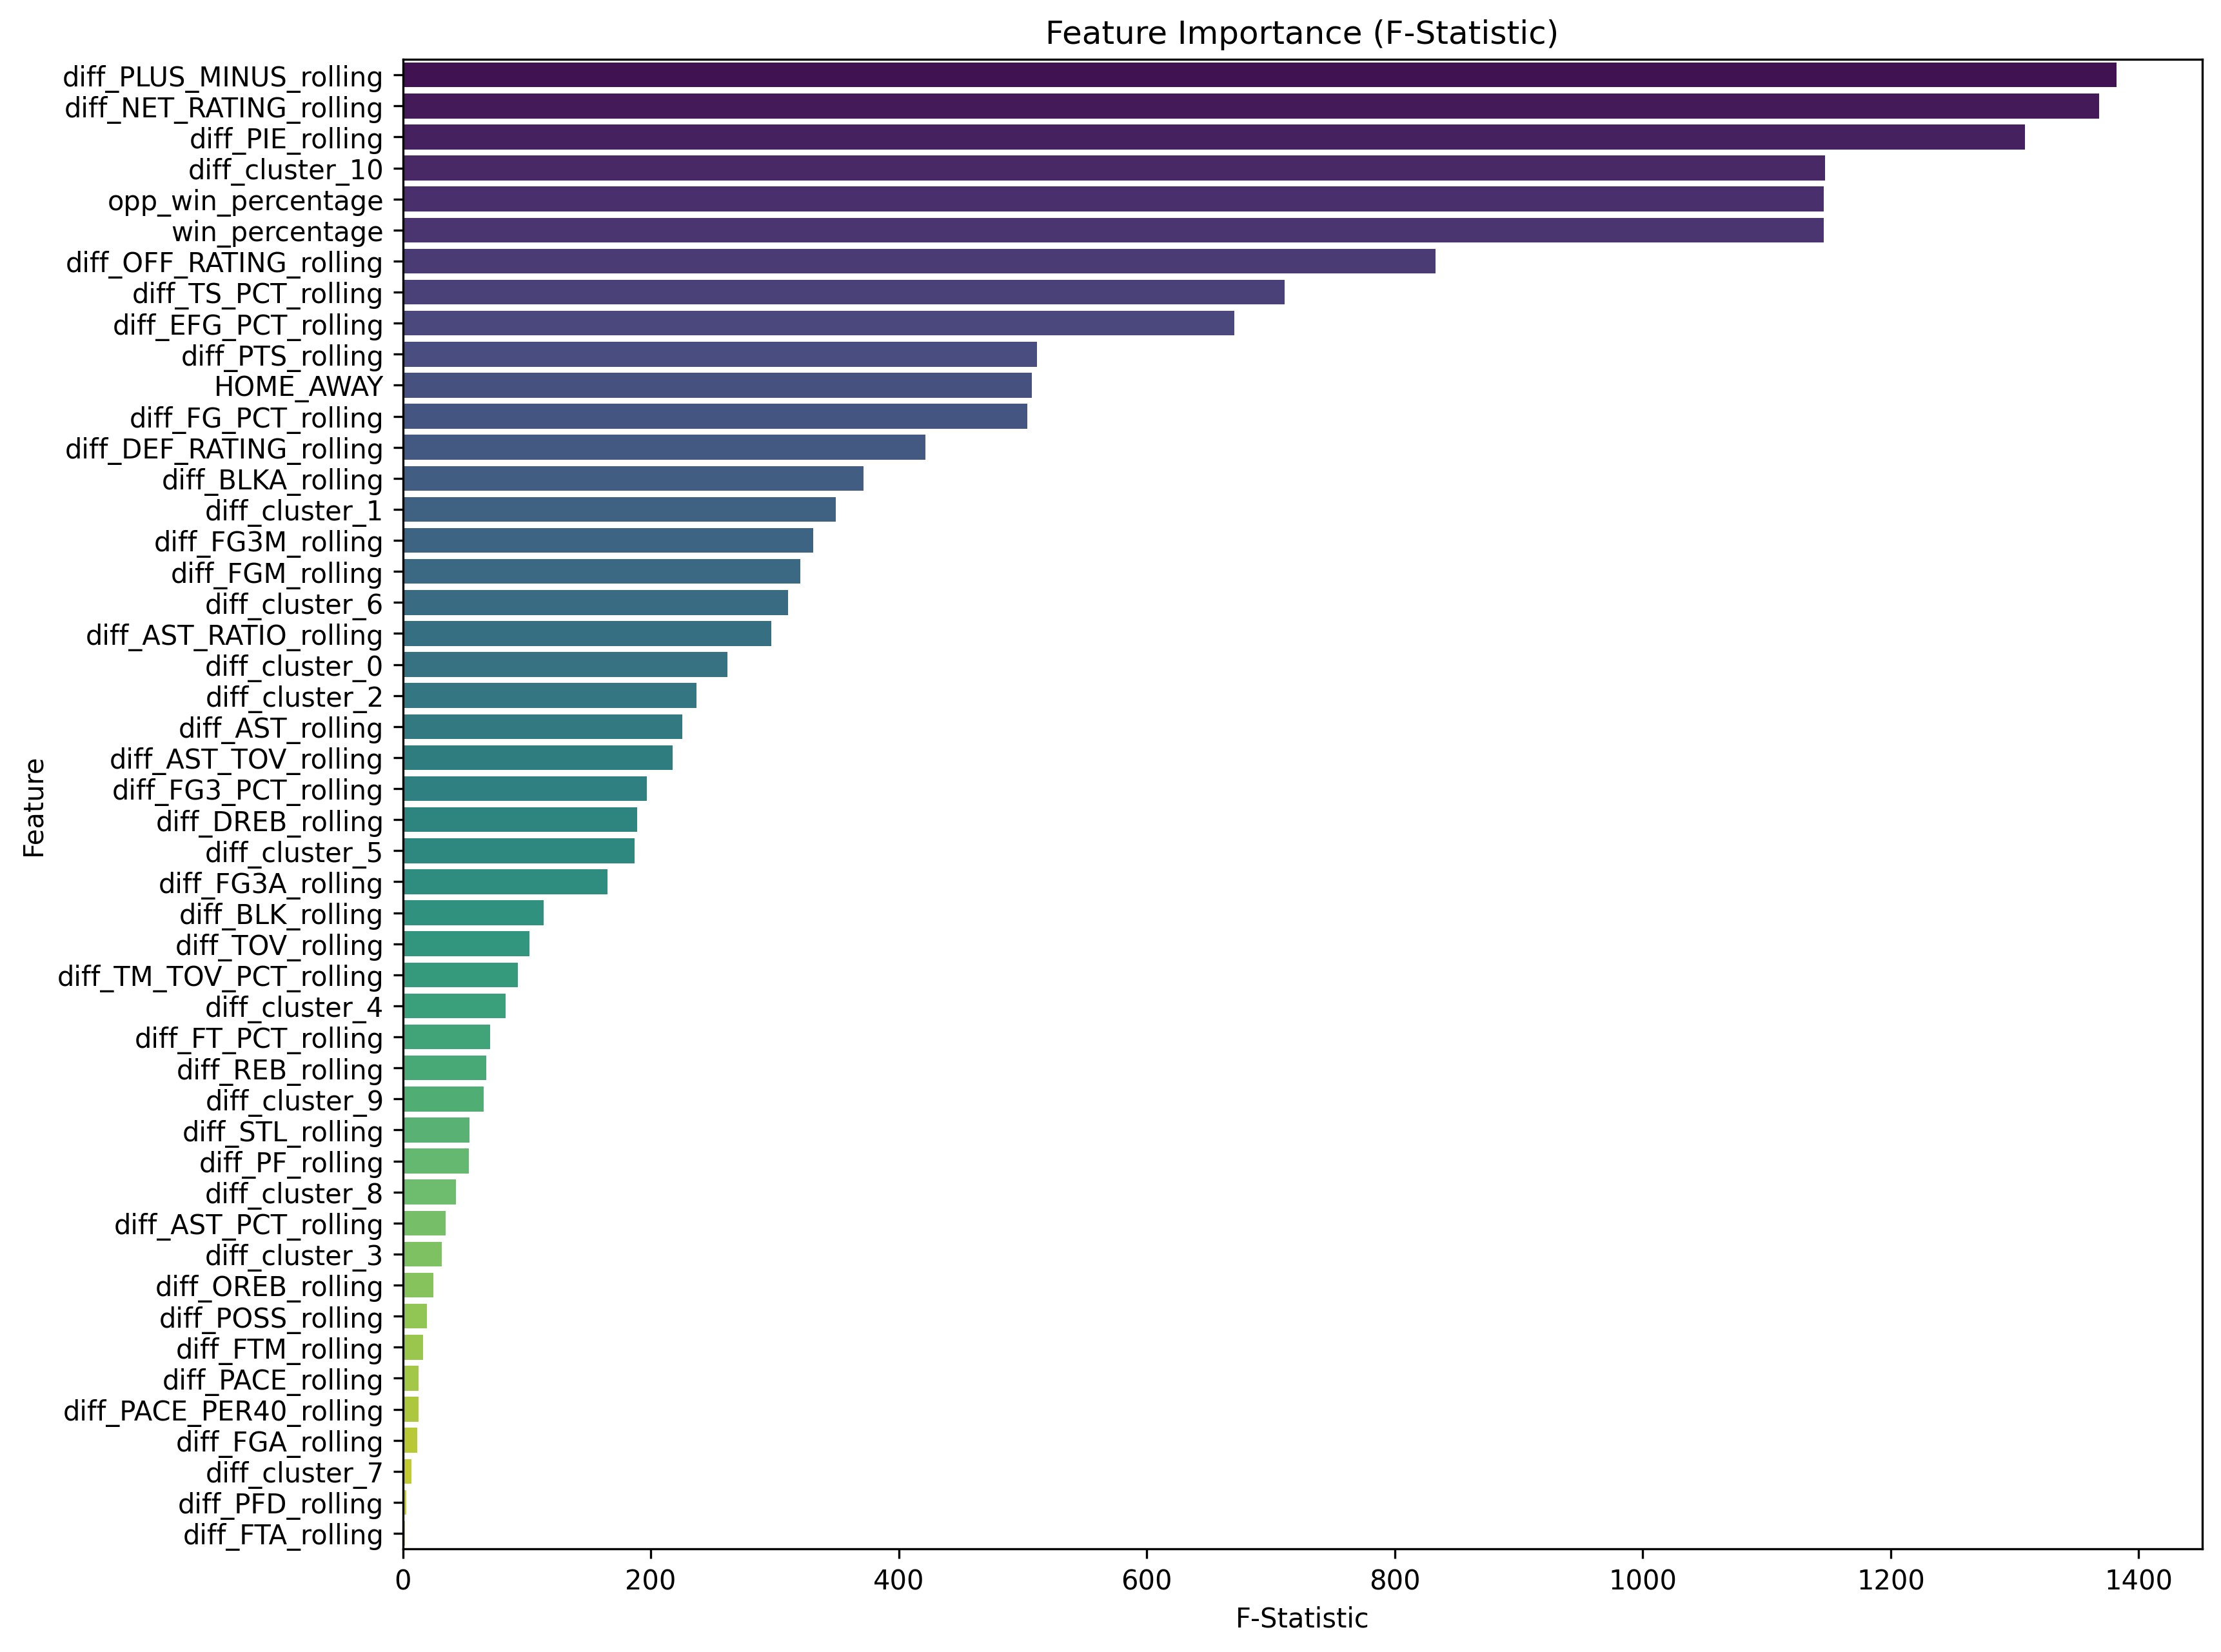

In [13]:
from sklearn.feature_selection import f_classif

y = df_model_cleaned[['WL']]
X = df_model_cleaned.drop('WL',axis=1).select_dtypes(include=['float64', 'int64']).drop(['TEAM_ID','GAME_ID'],axis = 1)
f_statistic, p_values = f_classif(X, y)

results_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Statistic': f_statistic,
    'p-Value': p_values
})
results_df = results_df.sort_values(by='F-Statistic', ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=300)

sns.barplot(x='F-Statistic', y='Feature', data=results_df, palette='viridis', ax=ax)
ax.set_title('Feature Importance (F-Statistic)')

plt.show()

# Training and Scaling

In [14]:
null_counts = df_model_cleaned.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


In [15]:
scaler = RobustScaler()

# Option A Train and Validation

In [16]:
df_val = df_model_cleaned[df_model_cleaned['SEASON_YEAR'].isin([ '2022-23', '2023-24'])]

#remaining seasons for training
df_train_val = df_model_cleaned[~df_model_cleaned['SEASON_YEAR'].isin([ '2022-23', '2023-24'])]

X_train = df_train_val.drop(columns=['SEASON_YEAR', 'WL'])
y_train_A = df_train_val['WL']

X_val = df_val.drop(columns=['SEASON_YEAR', 'WL'])
y_test_A = df_val['WL']

X_train_identifiers = X_train[['TEAM_ID', 'GAME_ID']]
X_val_identifiers = X_val[['TEAM_ID', 'GAME_ID']]

X_train = X_train.drop(columns=['TEAM_ID', 'GAME_ID'])
X_val = X_val.drop(columns=['TEAM_ID', 'GAME_ID'])

print(f"A Training set shape: {X_train.shape}")
print(f"A Validation set shape: {X_val.shape}")


X_train_scaled_A = scaler.fit_transform(X_train)
X_test_scaled_A = scaler.transform(X_val)

X_train_scaled_df_A = pd.DataFrame(X_train_scaled_A, columns=X_train.columns)
X_test_scaled_df_A = pd.DataFrame(X_test_scaled_A, columns=X_val.columns)

A Training set shape: (21160, 48)
A Validation set shape: (4820, 48)


# Option B: Train, Validation and Test

In [17]:
# final two seasons for the test set
df_test = df_model_cleaned[df_model_cleaned['SEASON_YEAR'].isin(['2022-23', '2023-24'])]

# remaining seasons for training and validation
df_train_val = df_model_cleaned[~df_model_cleaned['SEASON_YEAR'].isin(['2022-23', '2023-24'])]


X_train_val = df_train_val.drop(columns=['SEASON_YEAR', 'WL'])
y_train_val = df_train_val['WL']

X_test = df_test.drop(columns=['SEASON_YEAR', 'WL'])
y_test_B = df_test['WL']

# 80/20 split for training and val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_b, y_val_b = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

X_train_identifiers = X_train[['TEAM_ID', 'GAME_ID']]
X_val_identifiers = X_val[['TEAM_ID', 'GAME_ID']]
X_test_identifiers = X_test[['TEAM_ID', 'GAME_ID']]

X_train = X_train.drop(columns=['TEAM_ID', 'GAME_ID'])
X_val = X_val.drop(columns=['TEAM_ID', 'GAME_ID'])
X_test = X_test.drop(columns=['TEAM_ID', 'GAME_ID'])

print(f"B Training set shape: {X_train.shape}")
print(f"B Validation set shape: {X_val.shape}")
print(f"B Test set shape: {X_test.shape}")

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df_B = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df_B = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df_B = pd.DataFrame(X_test_scaled, columns=X_test.columns)

B Training set shape: (16928, 48)
B Validation set shape: (4232, 48)
B Test set shape: (4820, 48)


# Model

## Logistic Regression

## A

In [18]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled_df_A, y_train_A)

LogisticRegression(max_iter=1000, random_state=42)

In [19]:
y_test_pred = log_reg.predict(X_test_scaled_df_A)

val_accuracy = accuracy_score(y_test_A, y_test_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test_A, y_test_pred))

print("Classification Report:")
print(classification_report(y_test_A, y_test_pred))

Validation Accuracy: 0.6328
Confusion Matrix:
[[1525  885]
 [ 885 1525]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2410
           1       0.63      0.63      0.63      2410

    accuracy                           0.63      4820
   macro avg       0.63      0.63      0.63      4820
weighted avg       0.63      0.63      0.63      4820



## B

In [20]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled_df_B, y_train_b)

LogisticRegression(max_iter=1000, random_state=42)

In [21]:
y_test_pred = log_reg.predict(X_test_scaled_df_B)

val_accuracy = accuracy_score(y_test_B, y_test_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test_B, y_test_pred))

print("Classification Report:")
print(classification_report(y_test_B, y_test_pred))

Validation Accuracy: 0.6351
Confusion Matrix:
[[1526  884]
 [ 875 1535]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      2410
           1       0.63      0.64      0.64      2410

    accuracy                           0.64      4820
   macro avg       0.64      0.64      0.64      4820
weighted avg       0.64      0.64      0.64      4820



# XGBoost

### Option A 

In [26]:
param_grid = {
    'max_depth': [3,4,5,7],
    'learning_rate': [0.009,0.01,0.02],
    'n_estimators': [100,200,300,500,800],
    'subsample': [0.6,0.7,0.8],
    'colsample_bytree': [0.6,0.7,0.8,0.9]
}

xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled_df_A, y_train_A)

print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.009, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.7}
Best Validation Accuracy: 0.6521739130434783


In [22]:
import xgboost as xgb

# convert the dataset into DMatrix (optimized for XGBoost) -
dtrain = xgb.DMatrix(X_train_scaled_df_A, label=y_train_A)
dval = xgb.DMatrix(X_test_scaled_df_A, label=y_test_A)
params = {'colsample_bytree': 0.7, 'learning_rate': 0.009, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.7}


evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(params, dtrain, num_boost_round=600, early_stopping_rounds=5, evals=evals, verbose_eval=0)

y_val_pred = (xgb_model.predict(dval) > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test_A, y_val_pred))
print(confusion_matrix(y_test_A, y_val_pred))
print(classification_report(y_test_A, y_val_pred))

Test Accuracy: 0.6427385892116183
[[1538  872]
 [ 850 1560]]
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2410
           1       0.64      0.65      0.64      2410

    accuracy                           0.64      4820
   macro avg       0.64      0.64      0.64      4820
weighted avg       0.64      0.64      0.64      4820



### Option B

In [28]:
param_grid = {
    'max_depth': [3,4,5,7,10,11],
    'learning_rate': [0.009,0.01,0.02],
    'n_estimators': [100,200,300,500,800],
    'subsample': [0.6,0.7,0.8],
    'colsample_bytree': [0.6,0.7,0.8,0.9]
}

xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled_df_B, y_train_b)

print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Best Validation Accuracy: 0.6595577933641085


In [23]:
# convert the dataset into DMatrix (optimized for XGBoost) -
dtrain = xgb.DMatrix(X_train_scaled_df_B, label=y_train_b)
dval = xgb.DMatrix(X_val_scaled_df_B, label=y_val_b)
dtest = xgb.DMatrix(X_test_scaled_df_B, label=y_test_B)
params = {
    'n_estimators': 300,
    'eta': 0.01,  # learning rate
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}

evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(params, dtrain, num_boost_round=600, early_stopping_rounds=50, evals=evals, verbose_eval=0)

y_test_pred = (xgb_model.predict(dtest) > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test_B, y_test_pred))
print(confusion_matrix(y_test_B, y_test_pred))
print(classification_report(y_test_B, y_test_pred))

Test Accuracy: 0.6392116182572614
[[1543  867]
 [ 872 1538]]
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2410
           1       0.64      0.64      0.64      2410

    accuracy                           0.64      4820
   macro avg       0.64      0.64      0.64      4820
weighted avg       0.64      0.64      0.64      4820



### Playing with SHAP

#### Option A

In [30]:
# JS visualization for Jupyter
shap.initjs()

explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled_df_A)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_scaled_df_A.iloc[0,:])

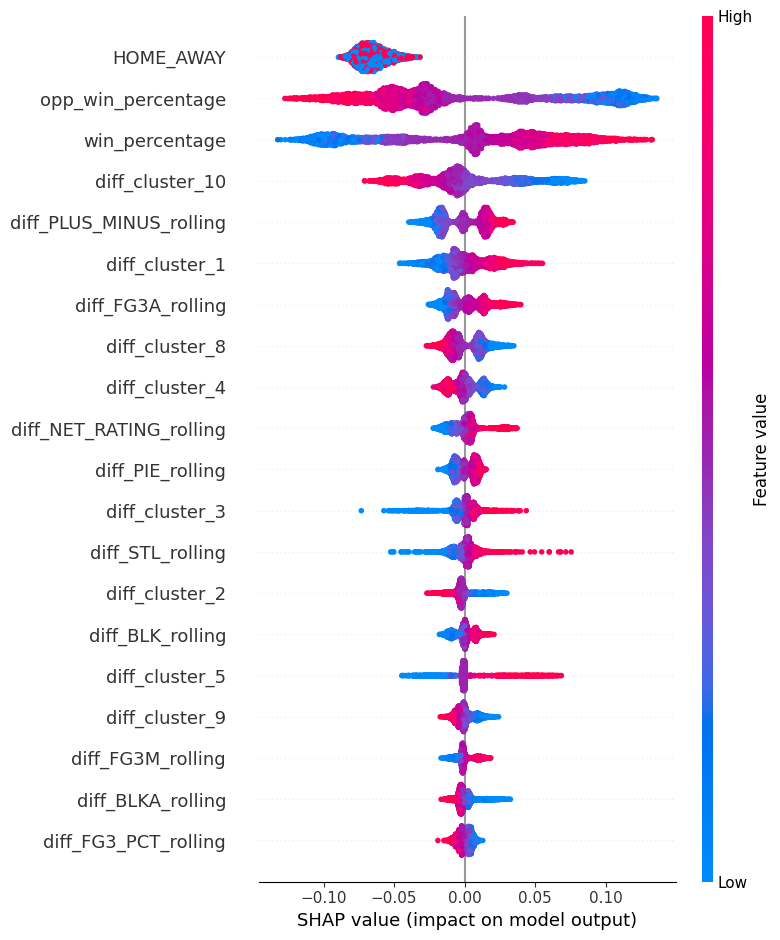

In [31]:
shap.summary_plot(shap_values, X_test_scaled_df_A)

In [32]:
dval = xgb.DMatrix(X_test_scaled_df_A)

explainer = shap.TreeExplainer(xgb_model)  # 'xgb_model' is your trained XGBoost model

shap_values = explainer.shap_values(dval)

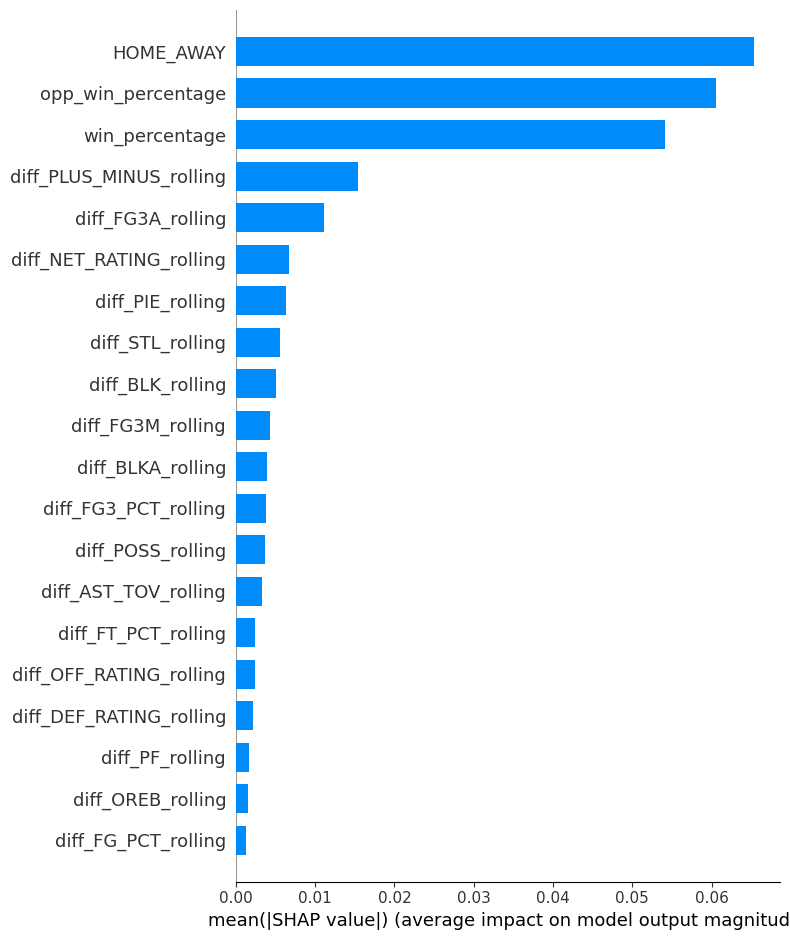

In [33]:
# Compute SHAP values with the full feature set
shap_values = explainer.shap_values(X_test_scaled_df_A)

# Exclude 'cluster' features from both SHAP values and the validation set
X_val_scaled_df_no_clusters = X_test_scaled_df_A.loc[:, ~X_test_scaled_df_A.columns.str.contains('cluster')]
shap_values_no_clusters = shap_values[:, ~X_test_scaled_df_A.columns.str.contains('cluster')]

# Create SHAP bar plot for feature importance without "cluster" features
shap.summary_plot(shap_values_no_clusters, X_val_scaled_df_no_clusters, plot_type="bar")

In [34]:
# Extract feature names without "cluster" features
feature_names_no_clusters = X_val_scaled_df_no_clusters.columns

# Iterate and print SHAP values for each feature
for feature_name, shap_value in zip(feature_names_no_clusters, shap_values_no_clusters.mean(0)):
    print(f"Feature: {feature_name}, SHAP value: {shap_value}")

Feature: HOME_AWAY, SHAP value: -0.06535652279853821
Feature: win_percentage, SHAP value: 0.0034577318001538515
Feature: opp_win_percentage, SHAP value: -0.004534780979156494
Feature: diff_FGM_rolling, SHAP value: 1.3872758245270234e-05
Feature: diff_FGA_rolling, SHAP value: -2.531693098717369e-05
Feature: diff_FG_PCT_rolling, SHAP value: -0.00014115624071564525
Feature: diff_FG3M_rolling, SHAP value: -0.00027491390937939286
Feature: diff_FG3A_rolling, SHAP value: 6.969612877583131e-05
Feature: diff_FG3_PCT_rolling, SHAP value: -8.156084368238226e-05
Feature: diff_FTM_rolling, SHAP value: -0.00010607233707560226
Feature: diff_FTA_rolling, SHAP value: -5.802497253171168e-05
Feature: diff_FT_PCT_rolling, SHAP value: -2.696995807127678e-06
Feature: diff_OREB_rolling, SHAP value: -9.36959077080246e-06
Feature: diff_DREB_rolling, SHAP value: 3.902722164639272e-05
Feature: diff_REB_rolling, SHAP value: -6.772841152269393e-05
Feature: diff_AST_rolling, SHAP value: -4.3649615690810606e-05
Feat

#### Option B

In [35]:
# JS visualization for Jupyter
shap.initjs()

explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled_df_B)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_scaled_df_B.iloc[0,:])

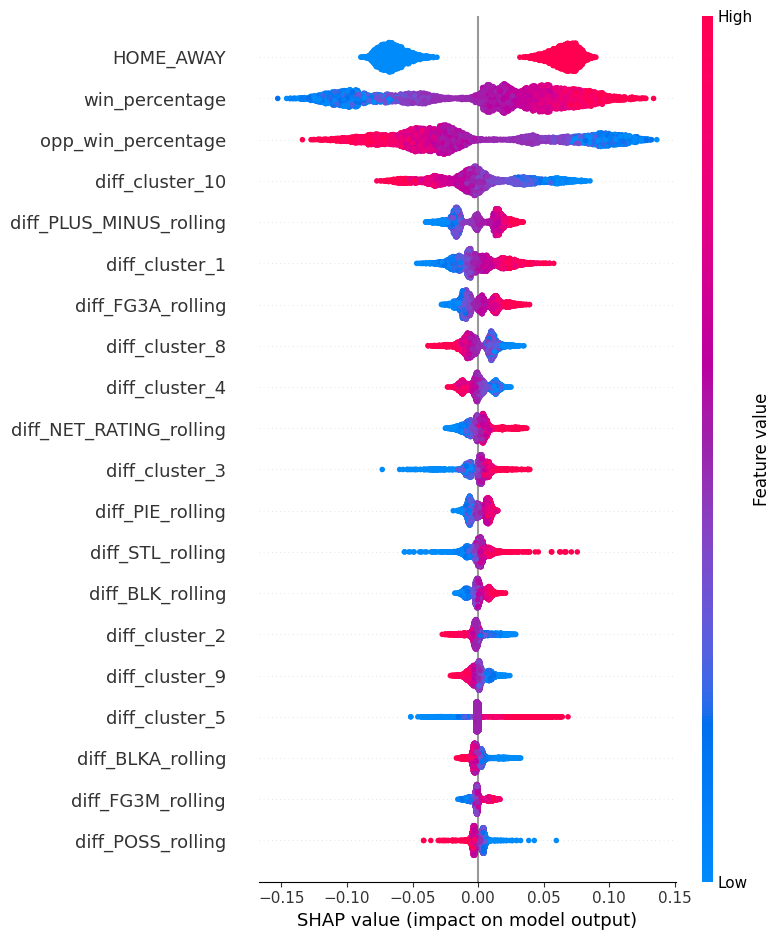

In [36]:
shap.summary_plot(shap_values, X_test_scaled_df_B)

In [37]:
dval = xgb.DMatrix(X_test_scaled_df_B)

explainer = shap.TreeExplainer(xgb_model)  # 'xgb_model' is your trained XGBoost model

shap_values = explainer.shap_values(dval)

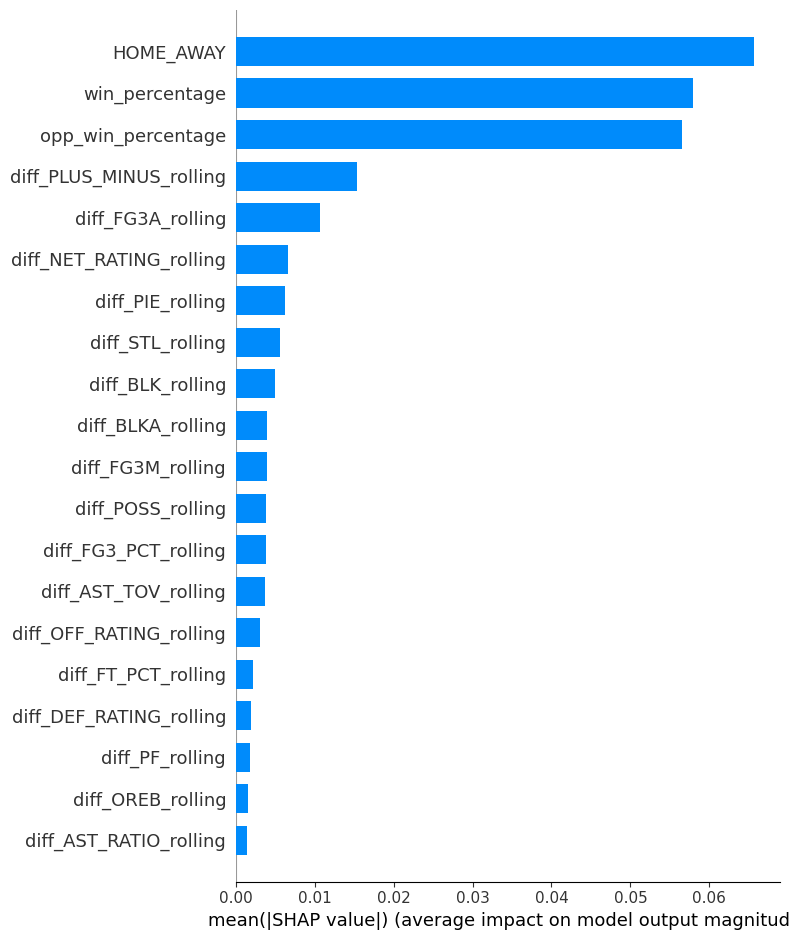

In [38]:
# Compute SHAP values with the full feature set
shap_values = explainer.shap_values(X_test_scaled_df_B)

# Exclude 'cluster' features from both SHAP values and the validation set
X_val_scaled_df_no_clusters = X_test_scaled_df_B.loc[:, ~X_test_scaled_df_B.columns.str.contains('cluster')]
shap_values_no_clusters = shap_values[:, ~X_test_scaled_df_B.columns.str.contains('cluster')]

# Create SHAP bar plot for feature importance without "cluster" features
shap.summary_plot(shap_values_no_clusters, X_val_scaled_df_no_clusters, plot_type="bar")

In [40]:
# Extract feature names without "cluster" features
feature_names_no_clusters = X_val_scaled_df_no_clusters.columns

# Iterate and print SHAP values for each feature
for feature_name, shap_value in zip(feature_names_no_clusters, shap_values_no_clusters.mean(0)):
    print(f"Feature: {feature_name}, SHAP value: {shap_value}")

Feature: HOME_AWAY, SHAP value: 0.00048506041639484465
Feature: win_percentage, SHAP value: 0.004717599600553513
Feature: opp_win_percentage, SHAP value: -0.004350700881332159
Feature: diff_FGM_rolling, SHAP value: 1.2986045476282015e-05
Feature: diff_FGA_rolling, SHAP value: 1.4180294783727732e-05
Feature: diff_FG_PCT_rolling, SHAP value: -0.00015037902630865574
Feature: diff_FG3M_rolling, SHAP value: -0.00018712470773607492
Feature: diff_FG3A_rolling, SHAP value: 2.27145883400226e-05
Feature: diff_FG3_PCT_rolling, SHAP value: -9.89336331258528e-05
Feature: diff_FTM_rolling, SHAP value: -3.258307697251439e-05
Feature: diff_FTA_rolling, SHAP value: 2.901925108744763e-05
Feature: diff_FT_PCT_rolling, SHAP value: 5.310350388754159e-06
Feature: diff_OREB_rolling, SHAP value: 9.62760896072723e-06
Feature: diff_DREB_rolling, SHAP value: 4.019711195724085e-05
Feature: diff_REB_rolling, SHAP value: -6.697412754874676e-05
Feature: diff_AST_rolling, SHAP value: 8.487084414809942e-06
Feature: di

## Neural Net

In [110]:
#prep Data
#convert to tensors
X_train_tensor = torch.tensor(X_train_scaled_df_B.values, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train_b.values, dtype=torch.float32).unsqueeze(1)  
X_val_tensor = torch.tensor(X_val_scaled_df_B.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_b.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled_df_B.values, dtype=torch.float32)  
y_test_tensor = torch.tensor(y_test_B.values, dtype=torch.float32).unsqueeze(1)

# combine into tensor dataset 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader instances
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle for training, No shuffle for testing, tried turning off for stability 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [111]:
device = torch.device('xpu')
# Define the main neural network model
class WinLossNet(nn.Module):
    def __init__(self,layer_sizes, drop_rate = 0.3685):
        super(WinLossNet, self).__init__()

        # main Layers
        self.fc1 = nn.Linear(48, layer_sizes[0])
        self.bn1 = nn.BatchNorm1d(layer_sizes[0])
        
        self.fc2 = nn.Linear(layer_sizes[0], layer_sizes[1])
        self.bn2 = nn.BatchNorm1d(layer_sizes[1])
        
        self.fc3 = nn.Linear(layer_sizes[1], layer_sizes[2])
        self.bn3 = nn.BatchNorm1d(layer_sizes[2])
        
        self.fc4 = nn.Linear(layer_sizes[2], layer_sizes[3])
        self.bn4 = nn.BatchNorm1d(layer_sizes[3])
        
        self.fc5 = nn.Linear(layer_sizes[3], layer_sizes[4])
        self.bn5 = nn.BatchNorm1d(layer_sizes[4])
        
        self.fc6 = nn.Linear(layer_sizes[4], 1)
        
        self.dropout = nn.Dropout(p=drop_rate)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        # main
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.leaky_relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

Epoch [2/20], Training Loss: 0.6356, Training Accuracy: 0.6456,Validation Loss: 0.6418, Validation Accuracy: 0.6340
Epoch [3/20], Training Loss: 0.6329, Training Accuracy: 0.6460,Validation Loss: 0.6379, Validation Accuracy: 0.6439
Epoch [4/20], Training Loss: 0.6315, Training Accuracy: 0.6499,Validation Loss: 0.6452, Validation Accuracy: 0.6385
Epoch [5/20], Training Loss: 0.6337, Training Accuracy: 0.6472,Validation Loss: 0.6416, Validation Accuracy: 0.6406
Epoch [6/20], Training Loss: 0.6311, Training Accuracy: 0.6489,Validation Loss: 0.6453, Validation Accuracy: 0.6323
Epoch [7/20], Training Loss: 0.6302, Training Accuracy: 0.6502,Validation Loss: 0.6490, Validation Accuracy: 0.6293
Epoch [8/20], Training Loss: 0.6293, Training Accuracy: 0.6535,Validation Loss: 0.6442, Validation Accuracy: 0.6444
Epoch [9/20], Training Loss: 0.6289, Training Accuracy: 0.6495,Validation Loss: 0.6398, Validation Accuracy: 0.6486
Epoch [10/20], Training Loss: 0.6245, Training Accuracy: 0.6561,Validati

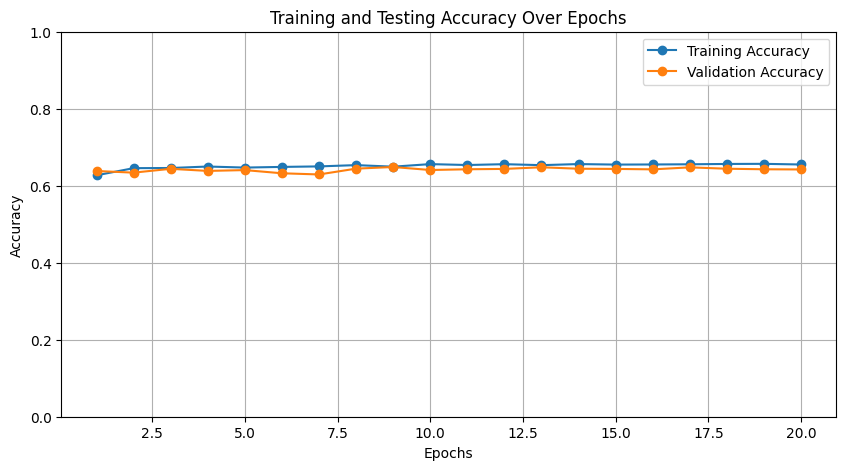

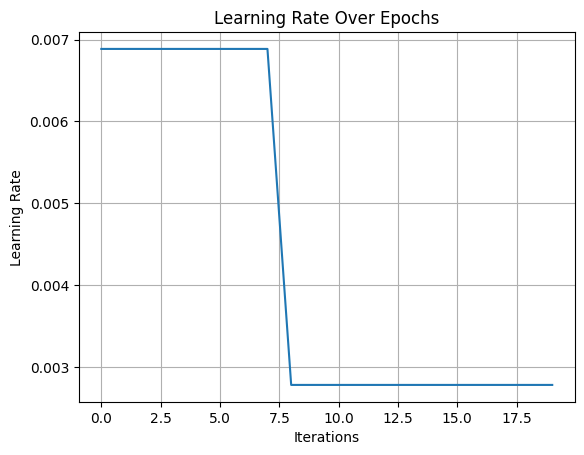

0.6342323651452282

In [128]:
# Instantiate the model, feed weights here to work with search function
model = WinLossNet([640, 420, 160, 80, 64])

#send to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()   # Combines Sigmoid + BCELoss, feeds data through sigmoid function
optimizer = optim.Adam(model.parameters(), lr= 0.006886,weight_decay=0.000795 )#1e-5)

########even more kaden fun, let 
model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.float32)


train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
learning_rates = []
# knobs
epochs = 20
#scheduler = StepLR(optimizer, step_size=17, gamma=.95)  # Change learning rate over time, different options to test
scheduler = ReduceLROnPlateau(optimizer,patience=7,factor=0.40432,cooldown=0)

for epoch in range(epochs):
    model.train()        # Training time
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)   #issue ******
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    # Calculte the trainging epocs stats
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_preds / total_preds
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)


    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val_preds += labels.size(0)
            correct_val_preds += (predicted == labels).sum().item()

    #calculate validation stats
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = correct_val_preds / total_val_preds
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    if epoch > 0:
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.4f},'
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    # Step the scheduler
    scheduler.step(epoch_val_loss)
    #save chnages in learning rate
    for param_group in optimizer.param_groups:
        learning_rates.append(param_group['lr'])

# Plot plot plot
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, epochs + 1), train_acc_history, label='Training Accuracy', marker='o')
plt.plot(np.arange(1, epochs + 1), val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Training and Testing Accuracy Over Epochs')
plt.xlabel('Epochs')

plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


plt.plot(learning_rates)
plt.title('Learning Rate Over Epochs')
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

true_values = []
predicted_values = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        true_values.append(labels.cpu().numpy())
        predicted_values.append(outputs.cpu().numpy())


true_values = np.concatenate(true_values)
predicted_values = np.concatenate(predicted_values)
predicted_values = (predicted_values >= 0.5).astype(int)
(predicted_values == true_values).mean()

In [129]:
#torch.save(model.state_dict(), 'NN_model.pth')

best_model = model
#to load model
best_model.load_state_dict(torch.load('NN_model.pth'))


<All keys matched successfully>

In [142]:
 best_model.eval()

true_values = []
predicted_values = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        true_values.append(labels.cpu().numpy())
        predicted_values.append(outputs.cpu().numpy())


true_values = np.concatenate(true_values)
predicted_values = np.concatenate(predicted_values)

results_df = pd.DataFrame({'True_Values':true_values.flatten(),
'pred_Values' : predicted_values.flatten()})
results_df['pred_Values_B'] = (results_df['pred_Values'] > 0.5).astype(int)
results_df = results_df.merge(X_val_identifiers.reset_index().drop('index',axis = 1), left_index=True, right_index=True)
results_df = results_df.merge(X_val.reset_index().drop('index',axis = 1),left_index=True, right_index=True)

predicted_values = (predicted_values >= 0.5).astype(int)
(predicted_values == true_values).mean()


0.6356846473029045

In [45]:
results_df['correct_prediction'] = (results_df['True_Values'] == results_df['pred_Values_B']).astype(int)
results_df

,True_Values,pred_Values,pred_Values_B,TEAM_ID,GAME_ID,HOME_AWAY,win_percentage,opp_win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,diff_FG3M_rolling,diff_FG3A_rolling,diff_FG3_PCT_rolling,diff_FTM_rolling,diff_FTA_rolling,diff_FT_PCT_rolling,diff_OREB_rolling,diff_DREB_rolling,diff_REB_rolling,diff_AST_rolling,diff_TOV_rolling,diff_STL_rolling,diff_BLK_rolling,diff_BLKA_rolling,diff_PF_rolling,diff_PFD_rolling,diff_PTS_rolling,diff_PLUS_MINUS_rolling,diff_OFF_RATING_rolling,diff_DEF_RATING_rolling,diff_NET_RATING_rolling,diff_AST_PCT_rolling,diff_AST_TOV_rolling,diff_AST_RATIO_rolling,diff_TM_TOV_PCT_rolling,diff_EFG_PCT_rolling,diff_TS_PCT_rolling,diff_PACE_rolling,diff_PACE_PER40_rolling,diff_POSS_rolling,diff_PIE_rolling,diff_cluster_0,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9,diff_cluster_10,correct_prediction
0,1.0,0.876251,1,1610612757,21900888,0,0.433333,0.295082,-3.00,-8.50,0.01000,-0.75,-8.00,0.06175,-7.25,-6.75,-0.10550,-2.75,-1.75,-4.50,-7.50,3.25,-0.25,2.00,-4.25,-2.00,-3.25,-14.00,-7.00,-10.375,-3.000,-7.350,-0.13275,-1.2125,-3.500,3.525,0.01200,-0.00575,-3.2500,-2.7075,-3.00,-0.02475,0.000000,-0.049300,0.000000,0.015300,0.063633,0.0,0.000000,-0.006067,0.000000,-0.071667,0.047833,1
1,0.0,0.778452,1,1610612761,21900439,1,0.714286,0.678571,1.00,-0.75,0.01675,-1.75,-6.00,0.01800,4.50,4.75,0.04450,0.00,-2.50,-2.50,0.50,-0.50,1.50,-0.50,0.50,0.00,0.50,4.75,8.00,3.600,-3.100,6.725,-0.00300,0.2850,0.275,-0.675,0.00775,0.01750,3.3550,2.7950,1.25,0.03150,0.000000,-0.074250,0.054375,0.200750,-0.188339,0.0,0.000000,-0.168357,-0.234000,-0.005696,0.017321,0
2,1.0,0.672016,1,1610612739,21401203,1,0.637500,0.387500,-7.00,-3.50,-0.06700,-1.75,8.00,-0.18575,3.25,3.25,0.05150,-0.50,-0.75,-1.25,-4.25,3.50,-0.50,-0.25,-1.00,-4.00,5.25,-12.50,-16.00,-14.725,2.100,-16.825,0.01425,-0.4475,-2.725,3.400,-0.07600,-0.05900,1.3750,1.1475,1.50,-0.10800,0.000000,-0.003686,-0.220600,-0.269457,-0.559857,0.0,0.090714,0.007286,0.108571,0.228000,0.000000,1
3,1.0,0.721337,1,1610612746,21300979,0,0.696970,0.338462,9.50,7.00,0.07300,0.00,-4.25,0.04625,0.50,2.00,-0.04100,0.50,3.50,4.00,7.00,1.00,3.25,2.75,-2.50,1.75,0.25,19.50,23.25,10.025,-13.300,23.325,0.04300,0.3175,3.250,-0.450,0.06825,0.05625,9.0000,7.5000,8.75,0.13400,0.000000,-0.141000,-0.001667,0.039000,0.302500,0.0,0.000000,-0.153000,-0.171000,-0.020167,0.000000,1
4,0.0,0.247445,0,1610612760,21500066,1,0.750000,1.000000,6.75,8.00,0.03650,1.00,2.00,0.01825,-3.00,-5.00,0.03675,3.50,0.50,4.00,1.75,2.75,-2.00,4.50,3.00,-2.00,-4.00,11.50,-4.75,5.075,9.100,-4.025,-0.04350,-0.0700,0.250,1.875,0.03900,0.02725,0.7375,0.6150,5.75,-0.02700,0.027857,0.109750,-0.067000,0.146036,0.052857,0.0,-0.083000,-0.074393,0.059946,-0.010268,-0.045625,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,1.0,0.680847,1,1610612737,21900272,0,0.222222,0.647059,-6.00,-1.00,-0.06250,-1.25,6.25,-0.10775,3.50,4.25,0.02525,-0.50,-7.25,-7.75,0.50,4.50,1.50,-1.50,3.25,7.25,2.25,-9.75,-28.50,-11.650,16.825,-28.475,0.08825,-0.5225,-0.400,4.225,-0.06825,-0.05575,1.7500,1.4550,1.75,-0.15950,0.000000,0.225571,0.021143,-0.328833,-0.032810,0.0,0.000000,-0.307143,0.127143,0.189548,-0.027214,1
4228,0.0,0.617821,1,1610612761,21600818,1,0.592593,0.462963,-2.50,-6.50,0.01075,4.00,6.75,0.07650,4.50,4.00,0.05025,-1.50,-3.00,-4.50,-4.75,-2.50,-1.00,-1.50,2.50,5.75,0.25,3.50,0.50,8.600,7.100,1.500,-0.08600,-0.1750,-1.975,-2.025,0.03650,0.04800,-3.7500,-3.1250,-4.00,-0.02400,-0.035714,0.004714,-0.032000,0.099286,0.073143,0.0,0.000000,-0.217714,0.089571,-0.273143,0.188857,0
4229,0.0,0.279101,0,1610612743,21700127,1,0.500000,0.428571,4.25,5.75,0.01950,3.50,-0.50,0.11775,2.75,6.75,-0.12225,2.25,-2.00,0.25,7.25,-5.00,2.25,1.00,1.00,-4.75,3.25,14.75,12.50,13.925,2.02

## Test: Model Blending

### Option A

In [115]:
y_test_A[:min_length]

NameError: name 'min_length' is not defined

In [ ]:
log_reg_pred_proba = log_reg.predict_proba(X_test_scaled_df_A)[:, 1]

xgb_val_pred_proba = xgb_model.predict(dval) 

best_model.eval()
nn_pred_proba = []
with torch.no_grad():
    for inputs, _ in test_loader: 
        inputs = inputs.to(device)
        outputs = torch.sigmoid(best_model(inputs))
        nn_pred_proba.extend(outputs.cpu().numpy()) 
nn_pred_proba = np.array(nn_pred_proba).flatten()


min_length = min(len(log_reg_pred_proba), len(xgb_val_pred_proba), len(nn_pred_proba))
log_reg_pred_proba = log_reg_pred_proba[:min_length]
xgb_val_pred_proba = xgb_val_pred_proba[:min_length]
nn_pred_proba = nn_pred_proba[:min_length]
nn_pred_proba_label = (nn_pred_proba > 0.5).astype(int)

#blended_test_proba = (log_reg_test_pred_proba + xgb_test_val_pred_proba + nn_test_pred_proba) / 3
#blended_pred = (blended_test_proba >= 0.5).astype(int)
blended_proba = (log_reg_pred_proba + xgb_val_pred_proba + nn_pred_proba) / 3
blended_pred = (blended_proba >= 0.5).astype(int)

blended_accuracy = accuracy_score(y_test_A[:min_length], blended_pred)
print(f"Blended Validation Accuracy: {blended_accuracy:.4f}")

print("Blended Confusion Matrix:")
print(confusion_matrix(y_test_A[:min_length], blended_pred))

print("Blended Classification Report:")
print(classification_report(y_test_A[:min_length], blended_pred))

In [138]:
len(xgb_val_pred_proba)

4232

In [139]:
len(nn_pred_proba)

4232

In [137]:
y_

4232

In [141]:
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test_B, nn_pred_proba_label))

print("Neural Netowkr Classification Report:")
print(classification_report(y_test_B, nn_pred_proba_label))

Neural Network Confusion Matrix:


ValueError: Found input variables with inconsistent numbers of samples: [4820, 4232]

In [48]:
print(f"log_reg_pred_proba shape: {log_reg_pred_proba.shape}")
print(f"xgb_val_pred_proba shape: {xgb_val_pred_proba.shape}")
print(f"nn_pred_proba shape: {nn_pred_proba.shape}")

log_reg_pred_proba shape: (4232,)
xgb_val_pred_proba shape: (4232,)
nn_pred_proba shape: (4232,)


### Option B

In [148]:
log_reg_pred_proba = log_reg.predict_proba(X_test_scaled_df_B)[:, 1]

xgb_val_pred_proba = xgb_model.predict(dval) 

model.eval()
nn_pred_proba = []
with torch.no_grad():
    for inputs, _ in test_loader: 
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs))
        nn_pred_proba.extend(outputs.cpu().numpy()) 
nn_pred_proba = np.array(nn_pred_proba).flatten()

min_length = min(len(log_reg_pred_proba), len(xgb_val_pred_proba), len(nn_pred_proba))
log_reg_pred_proba = log_reg_pred_proba[:min_length]
xgb_val_pred_proba = xgb_val_pred_proba[:min_length]
nn_pred_proba = nn_pred_proba[:min_length]

blended_proba = (log_reg_pred_proba + xgb_val_pred_proba + nn_pred_proba) / 3
blended_pred = (blended_proba >= 0.5).astype(int)

blended_accuracy = accuracy_score(y_test_B[:min_length], blended_pred)
print(f"Blended Validation Accuracy: {blended_accuracy:.4f}")

print("Blended Confusion Matrix:")
print(confusion_matrix(y_test_B[:min_length], blended_pred))

print("Blended Classification Report:")
print(classification_report(y_test_B[:min_length], blended_pred))

Blended Validation Accuracy: 0.6144
Blended Confusion Matrix:
[[1127  864]
 [ 768 1473]]
Blended Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      1991
           1       0.63      0.66      0.64      2241

    accuracy                           0.61      4232
   macro avg       0.61      0.61      0.61      4232
weighted avg       0.61      0.61      0.61      4232



In [149]:
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test_B, nn_pred_proba_label))

print("Neural Netowkr Classification Report:")
print(classification_report(y_test_B, nn_pred_proba_label))

Neural Network Confusion Matrix:
[[1422  988]
 [ 768 1642]]
Neural Netowkr Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      2410
           1       0.62      0.68      0.65      2410

    accuracy                           0.64      4820
   macro avg       0.64      0.64      0.63      4820
weighted avg       0.64      0.64      0.63      4820



## AUC for models/ Final Results

### Option A

In [51]:
log_reg_test_pred_proba = log_reg.predict_proba(X_test_scaled_df_A)[:, 1]  
log_reg_test_auc = roc_auc_score(y_test_A, log_reg_test_pred_proba)
print(f"Logistic Regression Test AUC: {log_reg_test_auc:.4f}")

xgb_test_val_pred_proba = xgb_model.predict(dtest)  
xgb_test_auc = roc_auc_score(y_test_A, xgb_test_val_pred_proba)
print(f"XGBoost Test AUC: {xgb_test_auc:.4f}")

nn_test_pred_proba = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs))
        nn_test_pred_proba.extend(outputs.cpu().numpy())
nn_test_pred_proba = np.array(nn_test_pred_proba).flatten()
nn_test_auc = roc_auc_score(y_test_A, nn_test_pred_proba)
print(f"Neural Network Test AUC: {nn_test_auc:.4f}")

blended_test_proba = (log_reg_test_pred_proba + xgb_test_val_pred_proba + nn_test_pred_proba) / 3  # avg prob
blended_test_auc = roc_auc_score(y_test_A, blended_test_proba)
print(f"Blended Model Test AUC: {blended_test_auc:.4f}")


Logistic Regression Test AUC: 0.6895
XGBoost Test AUC: 0.6912
Neural Network Test AUC: 0.6839
Blended Model Test AUC: 0.6912


In [49]:
log_reg_test_pred = log_reg.predict(X_test_scaled_df_A)
log_reg_test_accuracy = accuracy_score(y_test_A, log_reg_test_pred)
print(f"Logistic Regression Test Accuracy: {log_reg_test_accuracy:.4f}")

xgb_test_val_pred_proba = xgb_model.predict(dtest)
xgb_test_val_pred = (xgb_test_val_pred_proba > 0.5).astype(int) 
xgb_test_accuracy = accuracy_score(y_test_A, xgb_test_val_pred)
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")

nn_test_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs))
        nn_test_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))  
nn_test_pred = np.array(nn_test_pred).flatten()
nn_test_accuracy = accuracy_score(y_test_A, nn_test_pred)
print(f"Neural Network Test Accuracy: {nn_test_accuracy:.4f}")

blended_test_pred = (log_reg_test_pred + xgb_test_val_pred + nn_test_pred) >= 2  
blended_test_accuracy = accuracy_score(y_test_A, blended_test_pred)
print(f"Blended Model Test Accuracy: {blended_test_accuracy:.4f}")

Logistic Regression Test Accuracy: 0.6257
XGBoost Test Accuracy: 0.6392
Neural Network Test Accuracy: 0.6369
Blended Model Test Accuracy: 0.6423


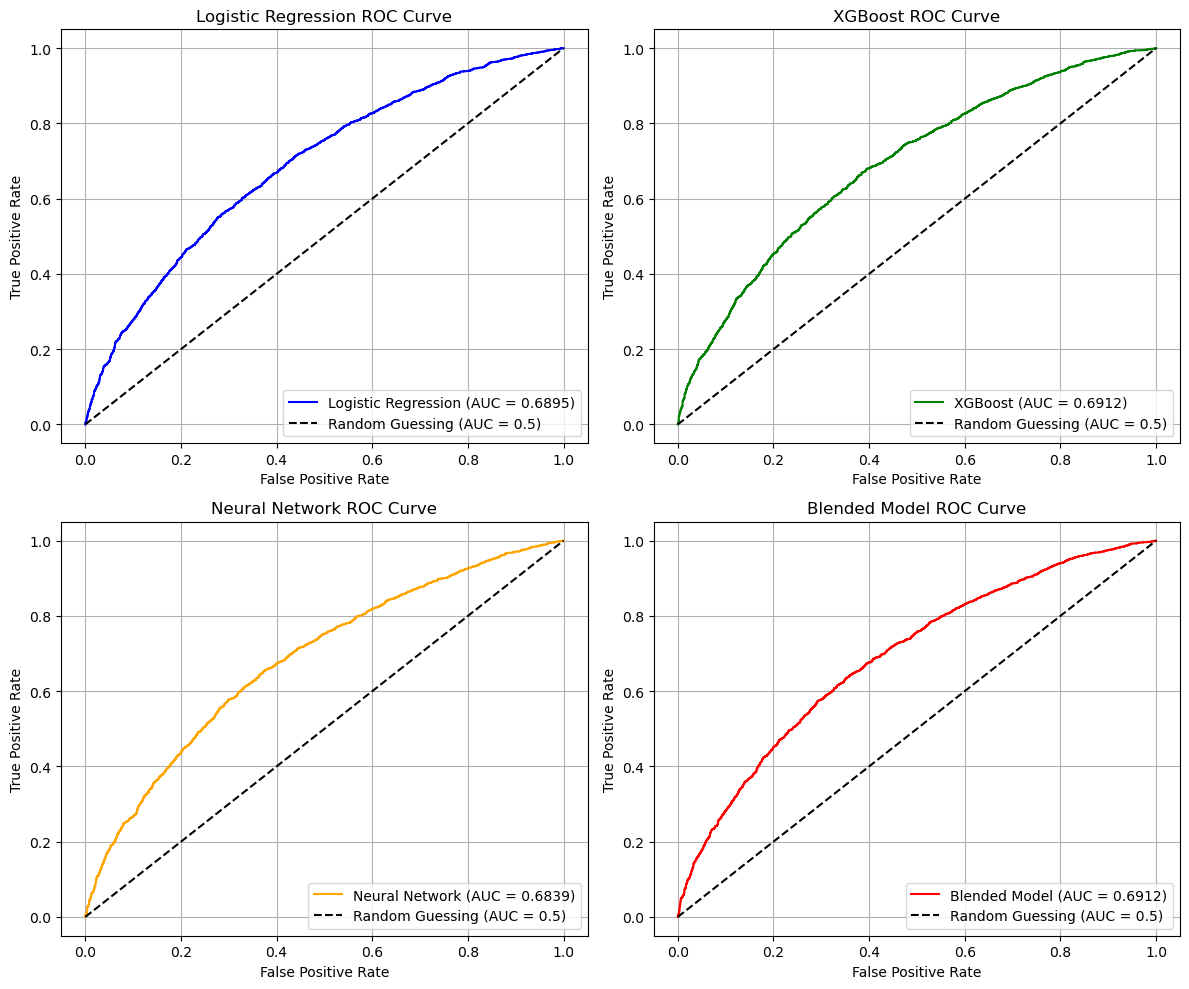

In [53]:
min_length = min(len(log_reg_test_pred_proba), len(xgb_test_val_pred_proba), len(nn_test_pred_proba), len(blended_test_proba), len(y_test_A))

log_reg_test_pred_proba = log_reg_test_pred_proba[:min_length]
xgb_test_val_pred_proba = xgb_test_val_pred_proba[:min_length]
nn_test_pred_proba = nn_test_pred_proba[:min_length]
blended_test_proba = blended_test_proba[:min_length]
y_test_A = y_test_A[:min_length]

log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test_A, log_reg_test_pred_proba)
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test_A, xgb_test_val_pred_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)

nn_fpr, nn_tpr, _ = roc_curve(y_test_A, nn_test_pred_proba)
nn_auc = auc(nn_fpr, nn_tpr)

blended_fpr, blended_tpr, _ = roc_curve(y_test_A, blended_test_proba)
blended_auc = auc(blended_fpr, blended_tpr)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(log_reg_fpr, log_reg_tpr, color='blue', label=f'Logistic Regression (AUC = {log_reg_auc:.4f})')
axs[0, 0].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[0, 0].set_title('Logistic Regression ROC Curve')
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].legend(loc='lower right')
axs[0, 0].grid(True)

axs[0, 1].plot(xgb_fpr, xgb_tpr, color='green', label=f'XGBoost (AUC = {xgb_auc:.4f})')
axs[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[0, 1].set_title('XGBoost ROC Curve')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].legend(loc='lower right')
axs[0, 1].grid(True)

axs[1, 0].plot(nn_fpr, nn_tpr, color='orange', label=f'Neural Network (AUC = {nn_auc:.4f})')
axs[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[1, 0].set_title('Neural Network ROC Curve')
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')
axs[1, 0].legend(loc='lower right')
axs[1, 0].grid(True)

axs[1, 1].plot(blended_fpr, blended_tpr, color='red', label=f'Blended Model (AUC = {blended_auc:.4f})')
axs[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[1, 1].set_title('Blended Model ROC Curve')
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].legend(loc='lower right')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

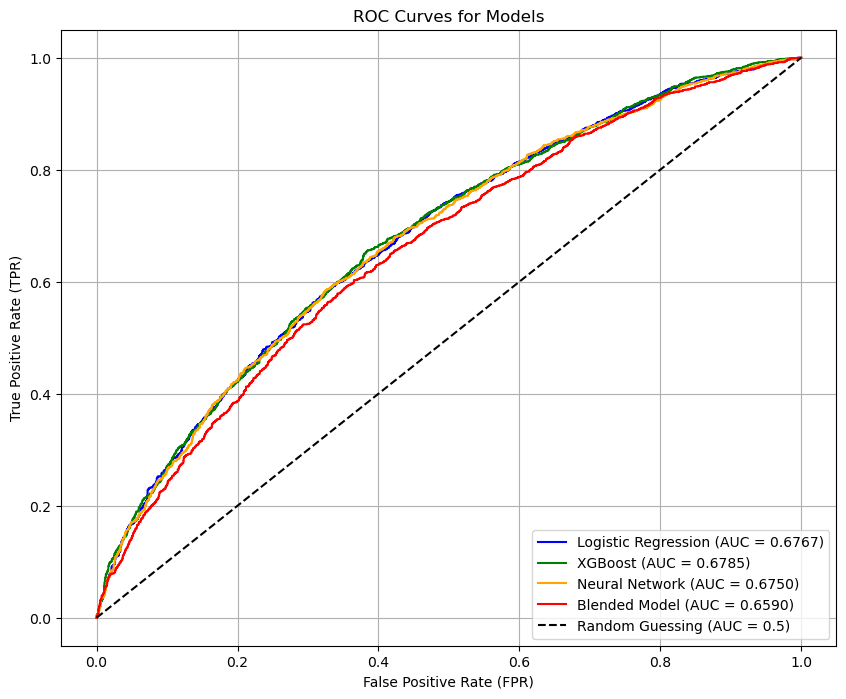

In [87]:
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test_A, log_reg_pred_proba)
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test_A, xgb_val_pred_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)

nn_fpr, nn_tpr, _ = roc_curve(y_test_A, nn_test_pred_proba)
nn_auc = auc(nn_fpr, nn_tpr)

blended_fpr, blended_tpr, _ = roc_curve(y_test_A, blended_proba)
blended_auc = auc(blended_fpr, blended_tpr)

plt.figure(figsize=(10, 8))
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.4f})', color='blue')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.4f})', color='green')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.4f})', color='orange')
plt.plot(blended_fpr, blended_tpr, label=f'Blended Model (AUC = {blended_auc:.4f})', color='red')

# 50% random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')

plt.title('ROC Curves for Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()